In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from patsy import dmatrices
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.api as sm
from math import sqrt
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
import datetime
from scipy import stats

In [2]:
df_all = pd.read_csv('df_all.csv')
df_all.set_index("date",inplace=True)
df_all.index=pd.to_datetime(df_all.index)
df_all = df_all.loc['2020-03-01':'2021-12-01']

num_day=list(range(1,642))
start_date = datetime.date(2020, 3, 1)
end_date = datetime.date(2021, 12, 2)
dates = [ start_date + datetime.timedelta(n) for n in range(int ((end_date - start_date).days))]

df_time=pd.DataFrame()
df_time['date']=dates
df_time['num_day']=num_day
df_time.columns=['date','num_day']
df_time.date=pd.to_datetime(df_time.date)

df_all.reset_index(inplace=True)

df_all=df_all.merge(df_time,on='date')
df_all

,date,Unnamed: 0,Unnamed: 0.1,country_code,country_name,continent,stringency_index_x,government_response_index,containment_health_index,economic_support_index,...,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,cluster,num_day
0,2020-03-13,0,0,ABW,Aruba,North America,0.00,2.08,2.38,0.0,...,NaN,NaN,76.29,NaN,NaN,NaN,NaN,NaN,NaN,13
1,2020-03-13,696,696,AFG,Afghanistan,Asia,27.78,22.92,26.19,0.0,...,37.746,0.50,64.83,0.511,NaN,NaN,NaN,NaN,2.0,13
2,2020-03-13,2062,2062,ALB,Albania,Europe,78.70,57.29,65.48,0.0,...,NaN,2.89,78.57,0.795,NaN,NaN,NaN,NaN,0.0,13
3,2020-03-13,2751,2751,AND,Andorra,Europe,9.26,20.83,16.67,50.0,...,NaN,NaN,83.73,0.868,NaN,NaN,NaN,NaN,NaN,13
4,2020-03-13,3473,3473,ARE,United Arab Emirates,Asia,34.26,27.60,31.55,0.0,...,NaN,1.20,77.97,0.890,NaN,NaN,NaN,NaN,0.0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111509,2020-03-12,112408,112408,TWN,Taiwan,Asia,28.70,31.25,32.14,25.0,...,NaN,NaN,80.46,NaN,NaN,NaN,NaN,NaN,0.0,12
111510,2020-03-12,114441,114441,UKR,Ukraine,Europe,50.00,31.77,34.52,12.5,...,NaN,8.80,72.06,0.779,NaN,NaN,NaN,NaN,NaN,12
111511,2020-03-12,115848,115848,USA,United States,North America,30.09,27.08,30.95,0.0,...,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN,1.0,12
111512,2020-03-12,117929,117929,VNM,Vietnam,Asia,47.22,36.98,42.26,0.0,...,85.847,2.60,75.40,0.704,NaN,NaN,NaN,NaN,3.0,12


In [3]:
cols=['country_name','date','num_day','cluster','c1_school_closing', 'c2_workplace_closing', 'c3_cancel_public_events',
       'c4_restrictions_on_gatherings', 'c5_close_public_transport',
       'c6_stay_at_home_requirements', 'c7_movementrestrictions',
       'c8_internationaltravel', 'e1_income_support', 'e2_debtrelief',
       'h1_public_information_campaigns', 'h2_testing_policy',
       'h3_contact_tracing', 'h6_facial_coverings', 'h7_vaccination_policy',
       'h8_protection_of_elderly_people','new_cases_smoothed']
df_reg=df_all[cols].dropna()
## create derived regression variable (date)
ds=df_reg.date
df_reg['Month']=ds.dt.month
df_reg['Day']=ds.dt.day
df_reg['Year']=ds.dt.year

df_reg.set_index("date",inplace=True)
df_reg.index=pd.to_datetime(df_reg.index)

df1=df_reg.copy()
df1=pd.concat((df1,pd.get_dummies(df_reg['cluster'])),axis=1)
df1=pd.concat((df1,pd.get_dummies(df_reg['Month'])),axis=1)

# 4.2.1 Regression for All Countries Data with Cluster and Time

In [4]:
df1=df1.loc[(df1['new_cases_smoothed']>0)]
df1.columns=['country_name','num_day','cluster', 'c1_school_closing', 'c2_workplace_closing', 'c3_cancel_public_events',
         'c4_restrictions_on_gatherings', 'c5_close_public_transport',
          'c6_stay_at_home_requirements', 'c7_movementrestrictions',
                'c8_internationaltravel', 'e1_income_support',
                         'e2_debtrelief', 'h1_public_information_campaigns',
                     'h2_testing_policy', 'h3_contact_tracing',
                   'h6_facial_coverings', 'h7_vaccination_policy',
       'h8_protection_of_elderly_people', 'new_cases_smoothed',
                                 'Month', 'Day', 'Year', 'cluster 0',  'cluster 1',  'cluster 2',
                                     'cluster 3',  'cluster 4', 'cluster 5',  'cluster 6',
                                    'cluster 7', 1, 2,  3,  4,  5, 6,  7, 8,   9, 10,  11, 12]
df1

,country_name,num_day,cluster,c1_school_closing,c2_workplace_closing,c3_cancel_public_events,c4_restrictions_on_gatherings,c5_close_public_transport,c6_stay_at_home_requirements,c7_movementrestrictions,...,3,4,5,6,7,8,9,10,11,12
date,,,,,,,,,,,,,,,,,,,,,
2020-03-13,Afghanistan,13,2.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
2020-03-13,United Arab Emirates,13,0.0,100.0,33.0,0.0,0.0,0.0,33.0,0.0,...,1,0,0,0,0,0,0,0,0,0
2020-03-13,Argentina,13,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
2020-03-13,Australia,13,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
2020-03-13,Austria,13,3.0,0.0,33.0,100.0,0.0,50.0,0.0,100.0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-12,Thailand,12,1.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
2020-03-12,Taiwan,12,0.0,33.0,0.0,50.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
2020-03-12,United States,12,1.0,100.0,0.0,100.0,50.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0


In [5]:
df_test=df1.loc[(df1['num_day'] >= 513) & (df1['num_day'] <= 641)]
df_train=df1.loc[(df1['num_day'] >= 1) & (df1['num_day'] <= 512)]

X=df_train.drop(labels=['country_name','cluster', 'c1_school_closing', 'c2_workplace_closing', 'c3_cancel_public_events',
         'c4_restrictions_on_gatherings', 'c5_close_public_transport',
          'c6_stay_at_home_requirements', 'c7_movementrestrictions',
                'c8_internationaltravel', 'e1_income_support',
                         'e2_debtrelief', 'h1_public_information_campaigns',
                     'h2_testing_policy', 'h3_contact_tracing',
                   'h6_facial_coverings', 'h7_vaccination_policy',
       'h8_protection_of_elderly_people', 'new_cases_smoothed',
                                 'Month', 'Day', 'Year', 1, 2,  3,  4,  5, 6,  7, 8,   9, 10,  11, 12],axis=1)


Y=df_train.new_cases_smoothed

X_test=df_test.drop(labels=['country_name','cluster', 'c1_school_closing', 'c2_workplace_closing', 'c3_cancel_public_events',
         'c4_restrictions_on_gatherings', 'c5_close_public_transport',
          'c6_stay_at_home_requirements', 'c7_movementrestrictions',
                'c8_internationaltravel', 'e1_income_support',
                         'e2_debtrelief', 'h1_public_information_campaigns',
                     'h2_testing_policy', 'h3_contact_tracing',
                   'h6_facial_coverings', 'h7_vaccination_policy',
       'h8_protection_of_elderly_people', 'new_cases_smoothed',
                                 'Month', 'Day', 'Year', 1, 2,  3,  4,  5, 6,  7, 8,   9, 10,  11, 12],axis=1)

Y_test=df_test.new_cases_smoothed

In [6]:
## Fit Poisson Regression

poisson_training_results = sm.GLM(Y, X, family=sm.families.Poisson()).fit()
print(poisson_training_results.summary())
print('\n')


                 Generalized Linear Model Regression Results                  
Dep. Variable:     new_cases_smoothed   No. Observations:                37986
Model:                            GLM   Df Residuals:                    37977
Model Family:                 Poisson   Df Model:                            8
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.5376e+08
Date:                Wed, 16 Mar 2022   Deviance:                   5.0724e+08
Time:                        17:35:28   Pearson chi2:                 1.59e+09
No. Iterations:                    11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
num_day        0.0031   5.72e-07   5406.506      0.0

In [7]:
## Check if valid for NB
1 - stats.chi2.cdf(1590000000, 37985)

0.0

In [8]:

df_train['LAMBDA'] = poisson_training_results.mu
df_train['AUX_OLS_DEP'] = df_train.apply(lambda x:((x['new_cases_smoothed'] - x['LAMBDA'])**2 - x['LAMBDA']) / x['LAMBDA'], axis=1)
ols_expr = """AUX_OLS_DEP ~ LAMBDA - 1"""
aux_olsr_results = smf.ols(ols_expr, df_train).fit()
print(aux_olsr_results.params)
print('\n')
print(aux_olsr_results.tvalues)
print('\n')


## Fit NB Regression

nb2_training_results = sm.GLM(Y, X,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()
print(nb2_training_results.summary())
print('\n')
nb2_predictions = nb2_training_results.get_prediction(X_test)
predictions_summary_frame = nb2_predictions.summary_frame()
print(predictions_summary_frame)
print('\n')
predicted_counts=predictions_summary_frame['mean']
#ci_low=predictions_summary_frame['mean_ci_lower']
#ci_up=predictions_summary_frame['mean_ci_lower']
actual_counts = Y_test
mse = sqrt(mean_squared_error(actual_counts, predicted_counts))
print('MSE: %.3f' % mse)

<ipython-input-8-8e9c2edfcf99>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['LAMBDA'] = poisson_training_results.mu
<ipython-input-8-8e9c2edfcf99>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['AUX_OLS_DEP'] = df_train.apply(lambda x:((x['new_cases_smoothed'] - x['LAMBDA'])**2 - x['LAMBDA']) / x['LAMBDA'], axis=1)


LAMBDA    10.111673
dtype: float64


LAMBDA    22.09771
dtype: float64


                 Generalized Linear Model Regression Results                  
Dep. Variable:     new_cases_smoothed   No. Observations:                37986
Model:                            GLM   Df Residuals:                    37977
Model Family:        NegativeBinomial   Df Model:                            8
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.2521e+05
Date:                Wed, 16 Mar 2022   Deviance:                       16660.
Time:                        17:35:41   Pearson chi2:                 3.05e+04
No. Iterations:                    15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------

# 4.2.2 Regression Example: China

### Also apply on Taiwan, Croatia, Afghanistan, Iran, New Zealand, Macau, Estonia, and China.

In [9]:
df1=df_reg.copy()
df1=pd.concat((df1,pd.get_dummies(df_reg['cluster'])),axis=1)
df1=pd.concat((df1,pd.get_dummies(df_reg['Month'])),axis=1)
df1=df1.loc[(df1['new_cases_smoothed']>0)&(df1['country_name']=='China')]
df1.columns=['country_name',                         'num_day',
                               'cluster',               'c1_school_closing',
                  'c2_workplace_closing',         'c3_cancel_public_events',
         'c4_restrictions_on_gatherings',       'c5_close_public_transport',
          'c6_stay_at_home_requirements',         'c7_movementrestrictions',
                'c8_internationaltravel',               'e1_income_support',
                         'e2_debtrelief', 'h1_public_information_campaigns',
                     'h2_testing_policy',              'h3_contact_tracing',
                   'h6_facial_coverings',           'h7_vaccination_policy',
       'h8_protection_of_elderly_people',              'new_cases_smoothed',
                                 'Month',                             'Day',
                                  'Year',                               'cluster 0',
                                     'cluster 1',                               'cluster 2',
                                     'cluster 3',                              'cluster 4',
                                    'cluster 5',                              'cluster 6',
                                    'cluster 7',                                 1,
                                       2,                                 3,
                                       4,                                 5,
                                       6,                                 7,
                                       8,                                 9,
                                      10,                                11,
                                      12]
df1

,country_name,num_day,cluster,c1_school_closing,c2_workplace_closing,c3_cancel_public_events,c4_restrictions_on_gatherings,c5_close_public_transport,c6_stay_at_home_requirements,c7_movementrestrictions,...,3,4,5,6,7,8,9,10,11,12
date,,,,,,,,,,,,,,,,,,,,,
2020-03-13,China,13,7.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,1,0,0,0,0,0,0,0,0,0
2020-03-14,China,14,7.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,1,0,0,0,0,0,0,0,0,0
2020-03-15,China,15,7.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,1,0,0,0,0,0,0,0,0,0
2020-03-16,China,16,7.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,1,0,0,0,0,0,0,0,0,0
2020-03-17,China,17,7.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-08,China,8,7.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,1,0,0,0,0,0,0,0,0,0
2020-03-09,China,9,7.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,1,0,0,0,0,0,0,0,0,0
2020-03-10,China,10,7.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,1,0,0,0,0,0,0,0,0,0


## Create Train, Test, Fit Poisson

In [10]:
df_test=df1.loc[(df1['num_day'] >= 513) & (df1['num_day'] <= 641)]
df_train=df1.loc[(df1['num_day'] >= 1) & (df1['num_day'] <= 512)]

X=df_train.drop(labels=['country_name','cluster','new_cases_smoothed',1,
                                     2,                                 3,
                                       4,                                 5,
                                       6,                                 7,
                                       8,                                 9,
                                      10,                                11,
                                      12,'Month',                             'Day',
                                  'Year','cluster 0',
                                     'cluster 1',                               'cluster 2',
                                     'cluster 3',                              'cluster 4',
                                    'cluster 5',                              'cluster 6',
                                    'cluster 7'],axis=1)

Y=df_train.new_cases_smoothed

X_test=df_test.drop(labels=['country_name','cluster','new_cases_smoothed',1,
                                     2,                                 3,
                                       4,                                 5,
                                       6,                                 7,
                                       8,                                 9,
                                      10,                                11,
                                      12,'Day','Month',                             'Day',
                                  'Year','cluster 0',
                                     'cluster 1',                               'cluster 2',
                                     'cluster 3',                              'cluster 4',
                                    'cluster 5',                              'cluster 6',
                                    'cluster 7'],axis=1)


Y_test=df_test.new_cases_smoothed



In [11]:


## Fit Poisson Regression

poisson_training_results = sm.GLM(Y, X, family=sm.families.Poisson()).fit()
print(poisson_training_results.summary())
print('\n')


                 Generalized Linear Model Regression Results                  
Dep. Variable:     new_cases_smoothed   No. Observations:                  512
Model:                            GLM   Df Residuals:                      496
Model Family:                 Poisson   Df Model:                           15
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5645.4
Date:                Wed, 16 Mar 2022   Deviance:                       8857.6
Time:                        17:36:03   Pearson chi2:                 1.04e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
num_day   

## First Chi-sqr Test For Poisson Model

In [12]:
1 - stats.chi2.cdf(10400, 511)

0.0

## Run This For Macao Only

In [ ]:
p_predictions = poisson_training_results.get_prediction(X_test)
predictions_summary_frame = p_predictions.summary_frame()
print(predictions_summary_frame)
print('\n')
predicted_counts=predictions_summary_frame['mean']
actual_counts = Y_test
mse = sqrt(mean_squared_error(actual_counts, predicted_counts))
print('MSE: %.3f' % mse)

## Fit NB2 For All Else

In [14]:

df_train['LAMBDA'] = poisson_training_results.mu
df_train['AUX_OLS_DEP'] = df_train.apply(lambda x:((x['new_cases_smoothed'] - x['LAMBDA'])**2 - x['LAMBDA']) / x['LAMBDA'], axis=1)
ols_expr = """AUX_OLS_DEP ~ LAMBDA - 1"""
aux_olsr_results = smf.ols(ols_expr, df_train).fit()
print(aux_olsr_results.params)
print('\n')
print(aux_olsr_results.tvalues)
print('\n')


## Fit NB Regression

nb2_training_results = sm.GLM(Y, X,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()
print(nb2_training_results.summary())
print('\n')
nb2_predictions = nb2_training_results.get_prediction(X_test)
predictions_summary_frame = nb2_predictions.summary_frame()
print(predictions_summary_frame)
print('\n')
predicted_counts=predictions_summary_frame['mean']
#ci_low=predictions_summary_frame['mean_ci_lower']
#ci_up=predictions_summary_frame['mean_ci_lower']
actual_counts = Y_test
mse = sqrt(mean_squared_error(actual_counts, predicted_counts))
print('MSE: %.3f' % mse)

LAMBDA    0.866765
dtype: float64


LAMBDA    14.175875
dtype: float64


                 Generalized Linear Model Regression Results                  
Dep. Variable:     new_cases_smoothed   No. Observations:                  512
Model:                            GLM   Df Residuals:                      496
Model Family:        NegativeBinomial   Df Model:                           15
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2119.6
Date:                Wed, 16 Mar 2022   Deviance:                       285.52
Time:                        17:36:20   Pearson chi2:                     339.
No. Iterations:                    12                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

<ipython-input-14-8e9c2edfcf99>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['LAMBDA'] = poisson_training_results.mu
<ipython-input-14-8e9c2edfcf99>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['AUX_OLS_DEP'] = df_train.apply(lambda x:((x['new_cases_smoothed'] - x['LAMBDA'])**2 - x['LAMBDA']) / x['LAMBDA'], axis=1)


## Second Chi-sqr Test For NB2

In [15]:
from scipy import stats
1 - stats.chi2.cdf(339, 511)

0.9999999995274685

## Plot the Prediction

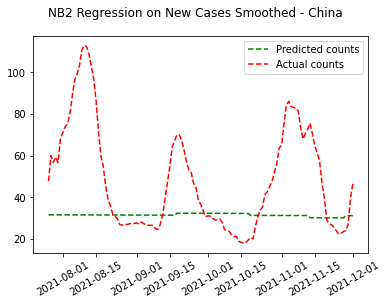

In [16]:
## Graph Prediction and Actual

fig = plt.figure()
fig.suptitle('NB2 Regression on New Cases Smoothed - China')
#training,  = plt.plot(df_train.index, Y.sort_index(), 'b--', label='Training')
predicted, = plt.plot(df_test.index, predicted_counts, 'g--', label='Predicted counts')
actual, = plt.plot(df_test.index, actual_counts, 'r--', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.xticks(rotation=30)

plt.show()